In [1]:
# Importing libraries
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.porter import PorterStemmer

import re

import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

c:\users\aditya pandey\appdata\local\programs\python\python36\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [3]:
con1 = sqlite3.connect("database.sqlite")

filtered_data = pd.read_sql_query("SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000", con1)

def partition(x):
    
    if x > 3:
        return "positive"
    return "negetive"

actualScore = filtered_data["Score"]
positiveNegetive = actualScore.map(partition)
filtered_data["Score"] = positiveNegetive

filtered_data.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negetive,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [5]:
sorted_data = filtered_data.sort_values("ProductId", axis=0, ascending = True, inplace = False,\
                                       kind = "quicksort", na_position = "last")

# deduplication
final = sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep="first",inplace = False)
final = final[final.HelpfulnessNumerator <= final.HelpfulnessDenominator]

print(final.shape)

(4986, 10)


In [6]:
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
words_to_keep = set(('not'))
stop -= words_to_keep
#initialising the snowball stemmer
sno = nltk.stem.SnowballStemmer('english')

 #function to clean the word of any html-tags
def cleanhtml(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

#function to clean the word of any punctuation or special characters
def cleanpunc(sentence): 
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [7]:
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    
    
    final_string.append(str1)
    i+=1

In [8]:
final["CleanedText"] = final_string
final["CleanedText"] = final["CleanedText"].str.decode("utf-8")
print(final.shape)

(4986, 11)


In [12]:
# Sort the data wrt time

time_sorted_data = final.sort_values("Time", axis=0, ascending=True, inplace = False, kind="quicksort", na_position = "last")
my_final = time_sorted_data.take(np.random.permutation(len(final)))

x = my_final["CleanedText"].values
print(x)

['love love love year old drink herbal tea quit often tasti'
 'like earth best babi food line organ ingredi amazon great price especi subscrib free deliveri doorstop conveni your busi mom daughter doesnt like lot babi food eat one review state bit runnier eb stage food add oatmeal also bit bland add dash cinnamon heat ad bonus work wonder digest tract problem constip month sometim go day give suppositori discov food make poop everi time also start give sippi cup water meal day help fiber rate instead star main ingredi sweet potato apricot rather sweet potato chicken wish chicken protein'
 'brew cup make thin good point ad creamer whip cream cinamin alway improv'
 ...
 'ive eat ramen noodl sinc littl kid ive never found better flavor hot spici chicken isnt hot chilihead like sure good'
 'must bit wuss soup tast imagin fire might tast typic like spici food good flavor dont find case soup flavor kill burn'
 'ive never heard safcol brand tire tri typic starkist chicken sea realli surpris t

## BoW

In [13]:
count_vect = CountVectorizer(min_df = 10) 
data_vec = count_vect.fit_transform(x)
print("the type of count vectorizer :",type(data_vec))
print("the shape of out text BOW vectorizer : ",data_vec.get_shape())
print("the number of unique words :", data_vec.get_shape()[1])

# Converting sparse matrix to dense matrix
data_dense = data_vec.toarray()

# Standardising the data
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
data = StandardScaler().fit_transform(data_dense)
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=100)
data = svd.fit_transform(data)

the type of count vectorizer : <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer :  (4986, 1854)
the number of unique words : 1854


In [16]:
# function for n-nearest neighbours
def n_neighbour(vectors , n):
    distance = []
    for point in vectors:
        temp = np.sort(np.sum((vectors-point)**2,axis=1),axis=None)
        distance.append(temp[n])
    return np.sqrt(np.array(distance))

In [14]:

def dbscan(epsilon, samples, Data):
    from sklearn.cluster import DBSCAN
    db = DBSCAN(eps=epsilon, min_samples=samples, n_jobs=-1).fit(Data)
    
    # Number of clusters in labels, ignoring noise(-1) if present.
    n_clusters = len(set(db.labels_))
    print("Number of clusters for MinPts = %d and Epsilon = %f is : %d "%(samples,epsilon,n_clusters))
    print("Labels(-1 is for Noise) : ",set(db.labels_))
    print()
    return db

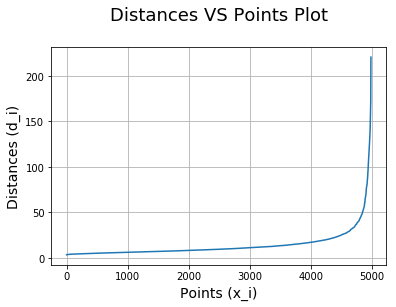

In [17]:
min_points = 2*data.shape[1]

# Computing distances of nth-nearest neighbours
distances = n_neighbour(data,min_points)
sorted_distance = np.sort(distances)
points = [i for i in range(data.shape[0])]

# Draw distances(d_i) VS points(x_i) plot
plt.plot(points, sorted_distance)
plt.xlabel('Points (x_i)',size=14)
plt.ylabel('Distances (d_i)',size=14)
plt.title('Distances VS Points Plot\n',size=18)
plt.grid()
plt.show()

In [18]:
optimal_eps = 30
# Clustering with right epsilon
db1 = dbscan(optimal_eps, min_points, data)


# Clustering with  epsilon = 40
db2 = dbscan(40, min_points, data)


# Clustering with epsilon = 50
db3 = dbscan(50, min_points, data)


# Clustering with epsilon = 60
db4 = dbscan(60, min_points, data)

Number of clusters for MinPts = 200 and Epsilon = 30.000000 is : 2 
Labels(-1 is for Noise) :  {0, -1}

Number of clusters for MinPts = 200 and Epsilon = 40.000000 is : 2 
Labels(-1 is for Noise) :  {0, -1}

Number of clusters for MinPts = 200 and Epsilon = 50.000000 is : 2 
Labels(-1 is for Noise) :  {0, -1}

Number of clusters for MinPts = 200 and Epsilon = 60.000000 is : 2 
Labels(-1 is for Noise) :  {0, -1}



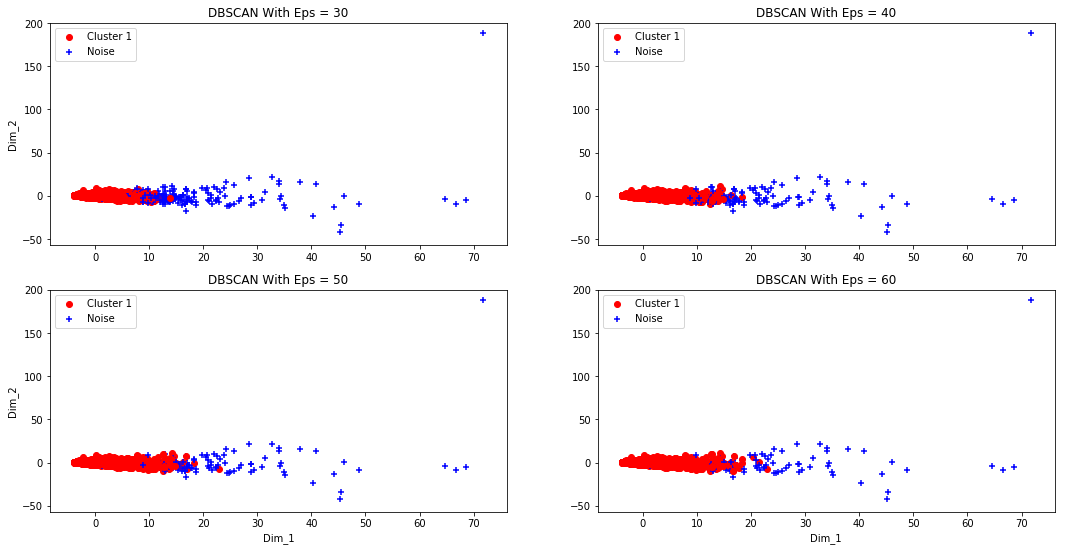

In [19]:
from sklearn.decomposition import PCA
pca_2d = PCA(n_components=2).fit_transform(data)

# Scatter plot for DBSCAN with Eps = 30
plt.figure(figsize=(18,9))
plt.subplot(221)
for i in range(0, pca_2d.shape[0]):
    if db1.labels_[i] == 0:
        c1 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='r',marker='o')
    elif db1.labels_[i] == -1:
        c2 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='b',marker='+')
plt.legend([c1, c2], ['Cluster 1', 'Noise'])  
plt.title('DBSCAN With Eps = 30')
plt.ylabel('Dim_2')

# Scatter plot for DBSCAN with Eps = 18
plt.subplot(222)
for i in range(0, pca_2d.shape[0]):
    if db2.labels_[i] == 0:
        c1 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='r',marker='o')
    elif db2.labels_[i] == -1:
        c2 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='b',marker='+')
plt.legend([c1, c2], ['Cluster 1', 'Noise'])  
plt.title('DBSCAN With Eps = 40')

# Scatter plot for DBSCAN with Eps = 20
plt.subplot(223)
for i in range(0, pca_2d.shape[0]):
    if db3.labels_[i] == 0:
        c1 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='r',marker='o')
    elif db3.labels_[i] == -1:
        c2 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='b',marker='+')
plt.legend([c1, c2], ['Cluster 1', 'Noise'])  
plt.title('DBSCAN With Eps = 50')
plt.ylabel('Dim_2')
plt.xlabel('Dim_1')

# Scatter plot for DBSCAN with Eps = 22
plt.subplot(224)
for i in range(0, pca_2d.shape[0]):
    if db4.labels_[i] == 0:
        c1 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='r',marker='o')
    elif db4.labels_[i] == -1:
        c2 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='b',marker='+')
plt.legend([c1, c2], ['Cluster 1', 'Noise'])  
plt.title('DBSCAN With Eps = 60')
plt.xlabel('Dim_1')

plt.show()

## Observations -->
    
    As the Eps increases the density of cluster increases and noise point decreases.